In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from glob import glob
from utils import *
from tqdm import tqdm

lidc_folder = "/home/cbel/Desktop/zhe/LIDC/"
data_folder = "/home/cbel/Desktop/zhe/data/"

In [2]:
# 擷取meta.csv中為CT的uid

df_meta = pd.read_csv(lidc_folder + "/LIDC-IDRI_MetaData.csv") # length = 1398
LIDC_detail = np.unique(df_meta["Modality"].values, return_counts=True)
print(LIDC_detail)

df_CT = df_meta[df_meta["Modality"] == "CT"]
df_CT = df_CT.sort_values(by = ["Patient Id"])

array_CT_seriesuid = df_meta[df_meta["Modality"] == "CT"]["Series UID"].to_numpy()

tmp = []
patientid_uid5 = {} # patient id - series uid (末五碼)
for i in range(1018):
    if df_CT.iloc[i]["Patient Id"] not in tmp:
        tmp.append(df_CT.iloc[i]["Patient Id"])
        patientid_uid5[df_CT.iloc[i]["Patient Id"]] = [df_CT.iloc[i]["Series UID"][-5:]]
    else:
        patientid_uid5[df_CT.iloc[i]["Patient Id"]].append(df_CT.iloc[i]["Series UID"][-5:])
        
# 找出需要的 case - dicom file

case_path = {}

dcm_folder1 = glob(lidc_folder + "/dicom/*")
dcm_folder1.sort()
i = 0
for path in dcm_folder1:
    patientid = path[-14:]
    dcm_folder2 = glob(path + "/*/*")
    for path2 in dcm_folder2:
        if path2[-5:] in patientid_uid5[patientid]:
            i += 1
            case = "%04d" %i
            case_path[case] = path2

(array(['CR', 'CT', 'DX', 'SEG'], dtype=object), array([  53, 1018,  237,   90]))


In [3]:
df = pd.read_csv(data_folder + "final_annotation.csv")
all_case = df["case"].unique()
all_diam = df["diam"].values
benign = df[df["malignancy"]==0]
malignancy = df[df["malignancy"]==1]
indeterminate = df[df["malignancy"]==2]
benign_diam = benign["diam"].values
malignancy_diam = malignancy["diam"].values
indeterminate_diam = indeterminate["diam"].values


all_slicenum = []
all_pixelspacing = []
all_slicethickness = []

# for i in tqdm(all_case):
i = all_case[0]
case = "%04d" %(i)
print(case)

dcm_path = glob(case_path[case] + "/*.dcm")
dcm_path.sort()
dcm = load_scan(dcm_path)
img_hu = get_pixels_hu(dcm)

slice_num = len(dcm)
pixel_spacing = dcm[0][0x28, 0x30].value
slice_thickness = dcm[0][0x18, 0x50].value

all_slicenum.append(slice_num)
all_pixelspacing.append(pixel_spacing[0])
all_slicethickness.append(slice_thickness)

0001


In [4]:
dcm[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.262721256650280657946440242654
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.26272

In [5]:
df = pd.read_csv(data_folder + "final_annotation.csv")
all_case = df["case"].unique()
all_diam = df["diam"].values
benign = df[df["malignancy"]==0]
malignancy = df[df["malignancy"]==1]
indeterminate = df[df["malignancy"]==2]
benign_diam = benign["diam"].values
malignancy_diam = malignancy["diam"].values
indeterminate_diam = indeterminate["diam"].values


all_slicenum = []
all_pixelspacing = []
all_slicethickness = []

for i in tqdm(all_case):
    case = "%04d" %(i)
    
    dcm_path = glob(case_path[case] + "/*.dcm")
    dcm_path.sort()
    dcm = load_scan(dcm_path)
    img_hu = get_pixels_hu(dcm)
    
    slice_num = len(dcm)
    pixel_spacing = dcm[0][0x28, 0x30].value
    slice_thickness = dcm[0][0x18, 0x50].value
    
    all_slicenum.append(slice_num)
    all_pixelspacing.append(pixel_spacing[0])
    all_slicethickness.append(slice_thickness)

100%|██████████| 697/697 [04:02<00:00,  2.88it/s]


max:  764
min:  65
mean: 245.81492109038737
median: 229.0


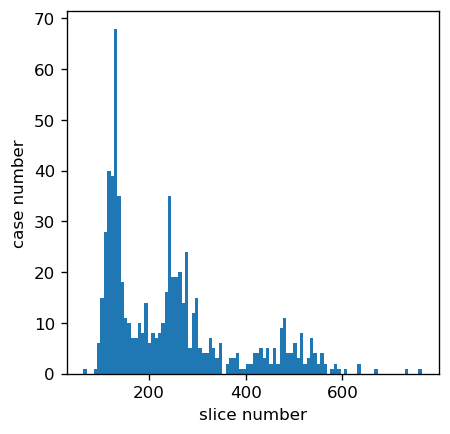

In [18]:
print("max: ", max(all_slicenum))
print("min: ", min(all_slicenum))
print("mean:", np.mean(all_slicenum))
print("median:", np.median(all_slicenum))
plt.hist(all_slicenum, bins=100)
plt.xlabel("slice number")
plt.ylabel("case number")
plt.show()

max:  0.9765625
min:  0.4609375
mean: 0.6915189982137733
median: 0.703125


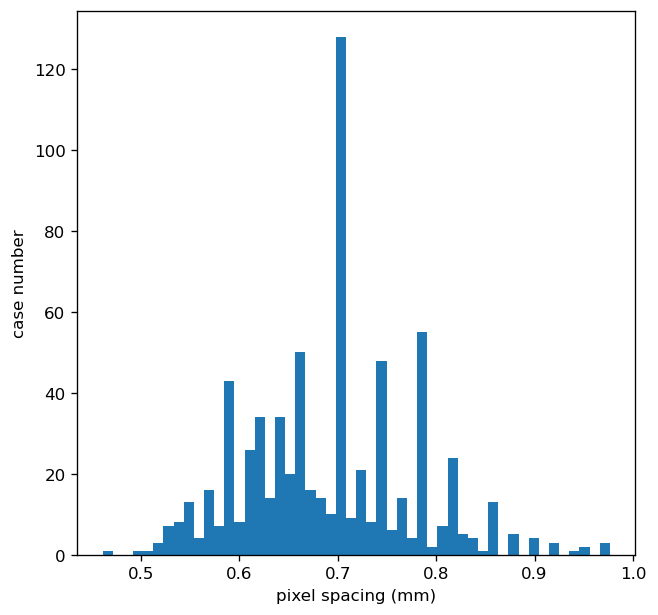

In [25]:
print("max: ", max(all_pixelspacing))
print("min: ", min(all_pixelspacing))
print("mean:", np.mean(all_pixelspacing))
print("median:", np.median(all_pixelspacing))
plt.figure(figsize=(6, 6), dpi=120)
plt.hist(all_pixelspacing, bins=50)
plt.xlabel("pixel spacing (mm)")
plt.ylabel("case number")
plt.savefig(data_folder + "/other/pixel_spacing.tiff")
plt.show()

max: 5.0
min: 0.4500120000000152
mean: 1.7009325985652797
median: 1.25


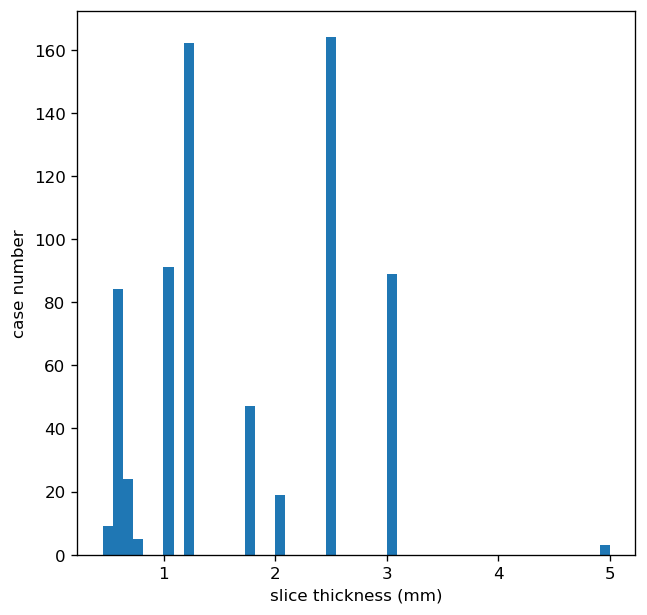

In [26]:
print("max:", max(all_slicethickness))
print("min:", min(all_slicethickness))
print("mean:", np.mean(all_slicethickness))
print("median:", np.median(all_slicethickness))
plt.figure(figsize=(6, 6), dpi=120)
plt.hist(all_slicethickness, bins=50)
plt.xlabel("slice thickness (mm)")
plt.ylabel("case number")
plt.savefig(data_folder + "/other/slice_thickness.tiff")
plt.show()

In [9]:
all_diam.shape

(1386,)

max: 32.684
min: 3.239
mean: 8.576694083694083
median: 6.694500000000001


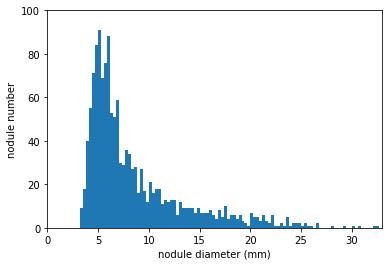

In [10]:
print("max:", max(all_diam))
print("min:", min(all_diam))
print("mean:", np.mean(all_diam))
print("median:", np.median(all_diam))
plt.hist(all_diam, bins=100)
plt.xlabel("nodule diameter (mm)")
plt.ylabel("nodule number")
plt.xlim([0, 33])
plt.ylim([0, 100])
plt.show()

In [11]:
for i in range(len(all_diam)):
    if all_diam[i] > 32:
        print(i)
        print(all_diam[i])
        print("-----")
    if all_diam[i] < 3:
        print(i)
        print(all_diam[i])
        print("-----")

116
32.286
-----
673
32.684
-----


In [12]:
def count_diam(nodule_diam):
    diam = np.arange(0, 34)
    values = np.zeros((len(diam)))
    diam_counter = dict(zip(diam, values))
    for d in nodule_diam:
        diam_counter[int(d)] += 1
    return diam_counter

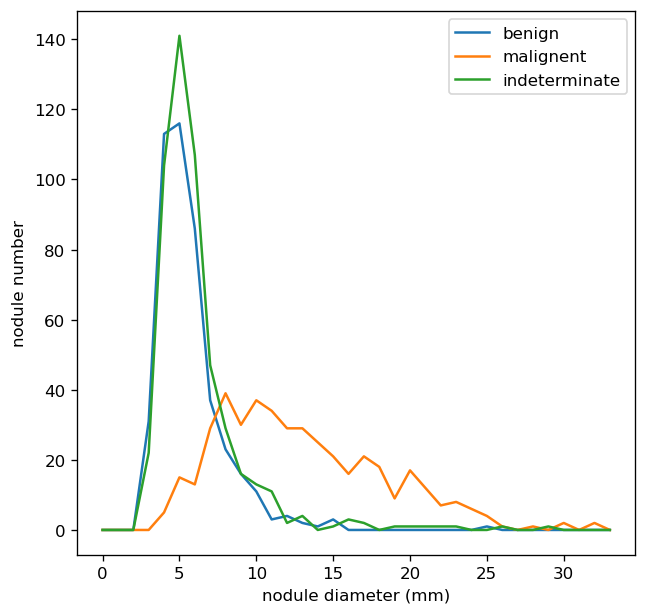

In [27]:
benign_diam_counter = count_diam(benign_diam)
malignancy_diam_counter = count_diam(malignancy_diam)
indeterminate_diam_counter = count_diam(indeterminate_diam)
plt.figure(figsize=(6, 6), dpi=120)
plt.plot(benign_diam_counter.keys(), benign_diam_counter.values())
plt.plot(malignancy_diam_counter.keys(), malignancy_diam_counter.values())
plt.plot(indeterminate_diam_counter.keys(), indeterminate_diam_counter.values())
plt.xlabel("nodule diameter (mm)")
plt.ylabel("nodule number")
plt.legend(["benign", "malignent", "indeterminate"])
plt.savefig(data_folder + "/other/nodule_diameters.tiff")
plt.show()

max: 25.581999999999997
min: 3.375
mean: 6.164024608501118
median: 5.722


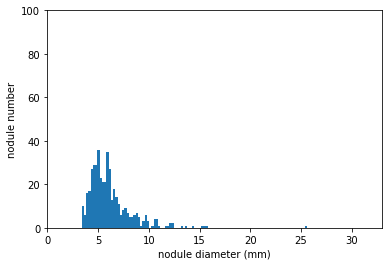

In [14]:
print("max:", max(benign_diam))
print("min:", min(benign_diam))
print("mean:", np.mean(benign_diam))
print("median:", np.median(benign_diam))
plt.hist(benign_diam, bins=100)
plt.xlabel("nodule diameter (mm)")
plt.ylabel("nodule number")
plt.xlim([0, 33])
plt.ylim([0, 100])
plt.show()

max: 32.684
min: 4.35
mean: 13.389567441860466
median: 12.393


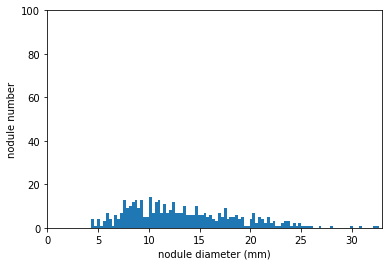

In [15]:
print("max:", max(malignancy_diam))
print("min:", min(malignancy_diam))
print("mean:", np.mean(malignancy_diam))
print("median:", np.median(malignancy_diam))
plt.hist(malignancy_diam, bins=100)
plt.xlabel("nodule diameter (mm)")
plt.ylabel("nodule number")
plt.xlim([0, 33])
plt.ylim([0, 100])
plt.show()

max: 29.401999999999997
min: 3.239
mean: 6.6295972495088415
median: 5.9079999999999995


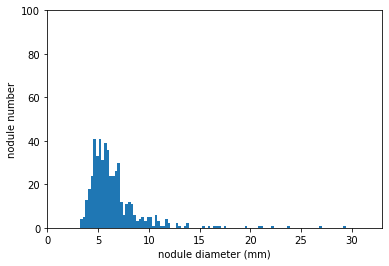

In [16]:
print("max:", max(indeterminate_diam))
print("min:", min(indeterminate_diam))
print("mean:", np.mean(indeterminate_diam))
print("median:", np.median(indeterminate_diam))
plt.hist(indeterminate_diam, bins=100)
plt.xlabel("nodule diameter (mm)")
plt.ylabel("nodule number")
plt.xlim([0, 33])
plt.ylim([0, 100])
plt.show()